In [ ]:
# 한글폰트 사용 in colab
%matplotlib inline  
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. 라이브러리 호출 

In [ ]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk python-dev python3-dev
# !pip install JPype1-py3
!pip install konlpy
# !JAVA_HOME="C:\Program Files\Java\jdk-19" # 각자의 jdk 경로
# !JAVA_HOME="C:\Program Files\Java\jre1.8.0_291" # 각자의 jdk 경로 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.5 MB/s 
     |████████████████████████████████| 465 kB 67.6 MB/s 


In [ ]:
# 데이터 전처리용
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from collections import Counter

# 데이터 호출
import pandas as pd
import numpy as np

# 기계학습
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models.word2vec import Word2Vec

# 워드클라우드
from wordcloud import WordCloud 
from PIL import Image 
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
okt = Okt()

# 1. 데이터 불러오기

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BOAZ/final.csv', index_col=False) #, encoding='cp949')

In [ ]:
data.head()

,Unnamed: 0,index,Column1,date,close,diff,open,high,low,volume,updown,등락률,날짜,언론사,제목,긍부정,링크,감성,감성수치
0,0,0,0,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,매경이코노미,‘오딘 개발사’ 품었다…카카오게임즈 주가 10% 급등,2,https://www.mk.co.kr/economy/view/2021/1034761,긍정,0.999828
1,1,1,1,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,국민일보,"카카오게임즈, ‘오딘’ 개발사 품는다",2,http://news.kmib.co.kr/article/view.asp?arcid=...,중립,0.737591
2,2,2,2,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,연합뉴스,"카카오게임즈, '오딘' 개발사 라이온하트 최대주주 된다(종합)",2,http://yna.kr/AKR20211101072551002?did=1195m,긍정,0.997663
3,3,3,3,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,조선비즈,"카카오게임즈, 2090억원 규모의 유상증자 결정",2,https://biz.chosun.com/stock/stock_general/202...,중립,0.999817
4,4,4,4,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,한국경제TV,"""게임주 극성수기 온다""…기관은 카카오게임즈 `찜` [박해린의 뉴스&마켓]",2,https://www.wowtv.co.kr/NewsCenter/News/Read?a...,부정,0.563029


In [ ]:
#df.drop_duplicates(subset=['brand'])
# data = data.drop_duplicates(subset=['토큰'])

In [ ]:
data.shape

(4475, 19)

In [ ]:
# 전날모다 오른 날의 데이터가 1.8천개, 전날 주가가 떨어진 데이터가 1.3천개 
data['긍부정'].value_counts()

2    1876
0    1342
1    1257
Name: 긍부정, dtype: int64

In [ ]:
# 14개 칼럼 중에 우리가 학습을 위해서 사용할 데이터는 '제목'하나다. 
X = data['제목']
y = data['긍부정']

In [ ]:
X = X.reset_index()['제목']

In [ ]:
y = y.reset_index()['긍부정']

In [ ]:
y

0       2
1       2
2       2
3       2
4       2
       ..
4470    1
4471    2
4472    2
4473    0
4474    0
Name: 긍부정, Length: 4475, dtype: int64

In [ ]:
X, y = X.to_numpy(), y.to_numpy()
X.shape, y.shape

((4475,), (4475,))

# 2. 텍스트 전처리

X는 현재 문장 데이터다. 이를 그대로 학습에 돌릴 수 없으니, 유효한 단어만 남기고 -> 워드 엠베딩 즉 토큰화를 거쳐서 학습에 용이한 형태로 바꾸어야 한다. 

전처리 중 불용어(stopwords)를 제거할 거다. stopwords 리스트는 구글에 나오는 것을 사용 

In [ ]:
stopwords_ko = ['!', '"', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.',
       '...', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ';', '<',
       '=', '>', '?', '@', '^', '_', '`', '|', '~', '·', '—', '——', '‘',
       '’', '“', '”', '…', '、', '。', '〈', '〉', '《', '》', '가', '가까스로',
       '가령', '각', '각각', '각자', '각종', '갖고말하자면', '같다', '같이', '개의치않고', '거니와',
       '거바', '거의', '것', '것과 같이', '것들', '게다가', '게우다', '겨우', '견지에서',
       '결과에 이르다', '결국', '결론을 낼 수 있다', '겸사겸사', '고려하면', '고로', '곧', '공동으로',
       '과', '과연', '관계가 있다', '관계없이', '관련이 있다', '관하여', '관한', '관해서는', '구',
       '구체적으로', '구토하다', '그', '그들', '그때', '그래', '그래도', '그래서', '그러나', '그러니',
       '그러니까', '그러면', '그러므로', '그러한즉', '그런 까닭에', '그런데', '그런즉', '그럼',
       '그럼에도 불구하고', '그렇게 함으로써', '그렇지', '그렇지 않다면', '그렇지 않으면', '그렇지만',
       '그렇지않으면', '그리고', '그리하여', '그만이다', '그에 따르는', '그위에', '그저', '그중에서',
       '그치지 않다', '근거로', '근거하여', '기대여', '기점으로', '기준으로', '기타', '까닭으로', '까악',
       '까지', '까지 미치다', '까지도', '꽈당', '끙끙', '끼익', '나', '나머지는', '남들', '남짓',
       '너', '너희', '너희들', '네', '넷', '년', '논하지 않다', '놀라다', '누가 알겠는가', '누구',
       '다른', '다른 방면으로', '다만', '다섯', '다소', '다수', '다시 말하자면', '다시말하면', '다음',
       '다음에', '다음으로', '단지', '답다', '당신', '당장', '대로 하다', '대하면', '대하여',
       '대해 말하자면', '대해서', '댕그', '더구나', '더군다나', '더라도', '더불어', '더욱더', '더욱이는',
       '도달하다', '도착하다', '동시에', '동안', '된바에야', '된이상', '두번째로', '둘', '둥둥',
       '뒤따라', '뒤이어', '든간에', '들', '등', '등등', '딩동', '따라', '따라서', '따위',
       '따지지 않다', '딱', '때', '때가 되어', '때문에', '또', '또한', '뚝뚝', '라 해도', '령',
       '로', '로 인하여', '로부터', '로써', '륙', '를', '마음대로', '마저', '마저도', '마치',
       '막론하고', '만 못하다', '만약', '만약에', '만은 아니다', '만이 아니다', '만일', '만큼',
       '말하자면', '말할것도 없고', '매', '매번', '메쓰겁다', '몇', '모', '모두', '무렵', '무릎쓰고',
       '무슨', '무엇', '무엇때문에', '물론', '및', '바꾸어말하면', '바꾸어말하자면', '바꾸어서 말하면',
       '바꾸어서 한다면', '바꿔 말하면', '바로', '바와같이', '밖에 안된다', '반대로', '반대로 말하자면',
       '반드시', '버금', '보는데서', '보다더', '보드득', '본대로', '봐', '봐라', '부류의 사람들',
       '부터', '불구하고', '불문하고', '붕붕', '비걱거리다', '비교적', '비길수 없다', '비로소', '비록',
       '비슷하다', '비추어 보아', '비하면', '뿐만 아니라', '뿐만아니라', '뿐이다', '삐걱', '삐걱거리다',
       '사', '삼', '상대적으로 말하자면', '생각한대로', '설령', '설마', '설사', '셋', '소생', '소인',
       '솨', '쉿', '습니까', '습니다', '시각', '시간', '시작하여', '시초에', '시키다', '실로',
       '심지어', '아', '아니', '아니나다를가', '아니라면', '아니면', '아니었다면', '아래윗', '아무거나',
       '아무도', '아야', '아울러', '아이', '아이고', '아이구', '아이야', '아이쿠', '아하', '아홉',
       '안 그러면', '않기 위하여', '않기 위해서', '알 수 있다', '알았어', '앗', '앞에서', '앞의것',
       '야', '약간', '양자', '어', '어기여차', '어느', '어느 년도', '어느것', '어느곳', '어느때',
       '어느쪽', '어느해', '어디', '어때', '어떠한', '어떤', '어떤것', '어떤것들', '어떻게', '어떻해',
       '어이', '어째서', '어쨋든', '어쩔수 없다', '어찌', '어찌됏든', '어찌됏어', '어찌하든지',
       '어찌하여', '언제', '언젠가', '얼마', '얼마 안 되는 것', '얼마간', '얼마나', '얼마든지',
       '얼마만큼', '얼마큼', '엉엉', '에', '에 가서', '에 달려 있다', '에 대해', '에 있다',
       '에 한하다', '에게', '에서', '여', '여기', '여덟', '여러분', '여보시오', '여부', '여섯',
       '여전히', '여차', '연관되다', '연이서', '영', '영차', '옆사람', '예', '예를 들면',
       '예를 들자면', '예컨대', '예하면', '오', '오로지', '오르다', '오자마자', '오직', '오호',
       '오히려', '와', '와 같은 사람들', '와르르', '와아', '왜', '왜냐하면', '외에도', '요만큼',
       '요만한 것', '요만한걸', '요컨대', '우르르', '우리', '우리들', '우선', '우에 종합한것과같이',
       '운운', '월', '위에서 서술한바와같이', '위하여', '위해서', '윙윙', '육', '으로', '으로 인하여',
       '으로서', '으로써', '을', '응', '응당', '의', '의거하여', '의지하여', '의해', '의해되다',
       '의해서', '이', '이 되다', '이 때문에', '이 밖에', '이 외에', '이 정도의', '이것', '이곳',
       '이때', '이라면', '이래', '이러이러하다', '이러한', '이런', '이럴정도로', '이렇게 많은 것',
       '이렇게되면', '이렇게말하자면', '이렇구나', '이로 인하여', '이르기까지', '이리하여', '이만큼', '이번',
       '이봐', '이상', '이어서', '이었다', '이와 같다', '이와 같은', '이와 반대로', '이와같다면',
       '이외에도', '이용하여', '이유만으로', '이젠', '이지만', '이쪽', '이천구', '이천육', '이천칠',
       '이천팔', '인 듯하다', '인젠', '일', '일것이다', '일곱', '일단', '일때', '일반적으로',
       '일지라도', '임에 틀림없다', '입각하여', '입장에서', '잇따라', '있다', '자', '자기', '자기집',
       '자마자', '자신', '잠깐', '잠시', '저', '저것', '저것만큼', '저기', '저쪽', '저희', '전부',
       '전자', '전후', '점에서 보아', '정도에 이르다', '제', '제각기', '제외하고', '조금', '조차',
       '조차도', '졸졸', '좀', '좋아', '좍좍', '주룩주룩', '주저하지 않고', '줄은 몰랏다', '줄은모른다',
       '중에서', '중의하나', '즈음하여', '즉', '즉시', '지든지', '지만', '지말고', '진짜로', '쪽으로',
       '차라리', '참', '참나', '첫번째로', '쳇', '총적으로', '총적으로 말하면', '총적으로 보면', '칠',
       '콸콸', '쾅쾅', '쿵', '타다', '타인', '탕탕', '토하다', '통하여', '툭', '퉤', '틈타',
       '팍', '팔', '퍽', '펄렁', '하', '하게될것이다', '하게하다', '하겠는가', '하고 있다',
       '하고있었다', '하곤하였다', '하구나', '하기 때문에', '하기 위하여', '하기는한데', '하기만 하면',
       '하기보다는', '하기에', '하나', '하느니', '하는 김에', '하는 편이 낫다', '하는것도',
       '하는것만 못하다', '하는것이 낫다', '하는바', '하더라도', '하도다', '하도록시키다', '하도록하다',
       '하든지', '하려고하다', '하마터면', '하면 할수록', '하면된다', '하면서', '하물며', '하여금',
       '하여야', '하자마자', '하지 않는다면', '하지 않도록', '하지마', '하지마라', '하지만', '하하',
       '한 까닭에', '한 이유는', '한 후', '한다면', '한다면 몰라도', '한데', '한마디', '한적이있다',
       '한켠으로는', '한항목', '할 따름이다', '할 생각이다', '할 줄 안다', '할 지경이다', '할 힘이 있다',
       '할때', '할만하다', '할망정', '할뿐', '할수있다', '할수있어', '할줄알다', '할지라도', '할지언정',
       '함께', '해도된다', '해도좋다', '해봐요', '해서는 안된다', '해야한다', '해요', '했어요', '향하다',
       '향하여', '향해서', '허', '허걱', '허허', '헉', '헉헉', '헐떡헐떡', '형식으로 쓰여', '혹시',
       '혹은', '혼자', '훨씬', '휘익', '휴', '흐흐', '흥', '힘입어', '︿', '！', '＃', '＄',
       '％', '＆', '（', '）', '＊', '＋', '，', '０', '１', '２', '３', '４', '５',
       '６', '７', '８', '９', '：', '；', '＜', '＞', '？', '＠', '［', '］', '｛',
       '｜', '｝', '～', '￥']

In [ ]:
# 한국어 전처리 함수
# 본인의 주제/데이터에 필요한 전처리를 선정하고, 직접 전처리 코드를 작성하거나 구글/깃헙에 공개된 타인의 코드를 활용

def clean_korean_documents(documents, stopwords_ko):

    # 텍스트 정제 (정규표현식을 이용한 특수기호 제거)

    # 텍스트 정제 (형태소 분석)
    for i, document in enumerate(documents):
        clean_words = []
        for word in okt.pos(document, stem=True): # 어간 추출
            if word[1] in ['Noun', 'Verb', 'Adjective']: # 명사/동사/형용사만 추출
                clean_words.append(word[0])
        document = ' '.join(clean_words)
        documents[i] = document

    # 텍스트 정제 (불용어 제거)
    for i, document in enumerate(documents):
        clean_words = [] 
        for word in word_tokenize(document): 
            if word not in stopwords_ko: # 불용어 제거
                clean_words.append(word)
        document = ' '.join(clean_words)
        documents[i] = document

    return documents

In [ ]:
# 2~3분 정도 걸린다. 
X = clean_korean_documents(X, stopwords_ko) # 텍스트 정제

In [ ]:
"""
기존 X는 
0                            ‘오딘 개발사’ 품었다…카카오게임즈 주가 10% 급등
1                                     카카오게임즈, ‘오딘’ 개발사 품는다
2                       카카오게임즈, '오딘' 개발사 라이온하트 최대주주 된다(종합)
3                               카카오게임즈, 2090억원 규모의 유상증자 결정
4                "게임주 극성수기 온다"…기관은 카카오게임즈 `찜` [박해린의 뉴스&마켓]
"""
# 핵심 단어만 남기고 문장이 깨끗해진 것을 알 수 있다. 
print(X[:5])

['오딘 개발 품다 카카오 게임 주가 급등' '카카오 게임 오딘 개발 품다'
 '카카오 게임 오딘 개발 라이온하트 최대 주주 되다 종합' '카카오 게임 규모 유상증자 결정'
 '게임 주 극성 수기 오다 기관 카카오 게임 찜 박해 린 뉴스 마켓']


In [ ]:
data.head()

,Unnamed: 0,index,Column1,date,close,diff,open,high,low,volume,updown,등락률,날짜,언론사,제목,긍부정,링크,감성,감성수치
0,0,0,0,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,매경이코노미,‘오딘 개발사’ 품었다…카카오게임즈 주가 10% 급등,2,https://www.mk.co.kr/economy/view/2021/1034761,긍정,0.999828
1,1,1,1,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,국민일보,"카카오게임즈, ‘오딘’ 개발사 품는다",2,http://news.kmib.co.kr/article/view.asp?arcid=...,중립,0.737591
2,2,2,2,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,연합뉴스,"카카오게임즈, '오딘' 개발사 라이온하트 최대주주 된다(종합)",2,http://yna.kr/AKR20211101072551002?did=1195m,긍정,0.997663
3,3,3,3,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,조선비즈,"카카오게임즈, 2090억원 규모의 유상증자 결정",2,https://biz.chosun.com/stock/stock_general/202...,중립,0.999817
4,4,4,4,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,한국경제TV,"""게임주 극성수기 온다""…기관은 카카오게임즈 `찜` [박해린의 뉴스&마켓]",2,https://www.wowtv.co.kr/NewsCenter/News/Read?a...,부정,0.563029


In [ ]:
data['토큰'] = X

In [ ]:
len(set(X))

4176

In [ ]:
data.to_csv('/content/drive/MyDrive/BOAZ/rows4475_with_token.csv')

In [ ]:
np.save('cleaned_x.npy', X)

# 3. 토큰화 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tf_x_data = tfidf_vectorizer.fit_transform(X) # 텍스트에 포함된 단어들의 TF-IDF 가중치 계산

print("텍스트의 TF-IDF 가중치 예시:")
print(tfidf_vectorizer.vocabulary_) # {'오딘': 2282, '개발': 83, '품다': 3445, '카카오': 3154, '게임': 131, '주가': 2835 ...}
print(len(tfidf_vectorizer.vocabulary_))
 

텍스트의 TF-IDF 가중치 예시:
{'오딘': 2282, '개발': 83, '품다': 3445, '카카오': 3154, '게임': 131, '주가': 2835, '급등': 350, '라이온하트': 871, '최대': 3084, '주주': 2859, '되다': 777, '종합': 2831, '규모': 312, '유상증자': 2431, '결정': 154, '극성': 323, '수기': 1791, '오다': 2281, '기관': 357, '박해': 1203, '뉴스': 564, '마켓': 975, '이유': 2511, '국내': 290, '주식': 2851, '유럽': 2424, '인수': 2546, '열사': 2256, '추가': 3094, '취득': 3125, '바람': 1184, '올라타다': 2313, '게임빌': 135, '날다': 469, '강세': 68, '어비스': 2134, '위메이드': 2400, '어닝': 2127, '서프라이즈': 1663, '하다': 3493, '코스피': 3196, '위로': 2398, '자회사': 2630, '출자': 3119, '크래프톤': 3214, '편입': 3390, '유력': 2425, '확보': 3648, '법인': 1314, '스튜디오': 1868, '계약': 175, '앞두다': 2083, '밸류': 1291, '프린세스': 3466, '커넥트': 3167, '신규': 1925, '한정': 3525, '캐릭터': 3161, '무기': 1102, '할로윈': 3531, '업데이트': 2153, '코스닥': 3193, '월간': 2382, '동향': 774, '투자자': 3304, '집중': 2970, '매수': 1016, '오늘': 2280, '공시': 227, '건설': 115, '금일': 345, '산업': 1586, '기사': 373, '이다': 2472, '평균': 3394, '사고': 1530, '보상': 1347, '이용자': 2509, '분통': 1428, '회사': 3674, '신작': 1936

In [ ]:
# 위 3727 단어에 대한 모든 tf-idf 각 값을 데이터마다 갖고 있는 tf_x_data
tf_x_data[0]

<1x3727 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Row format>

# 4. 모델 생성

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

model_nb = MultinomialNB(alpha=1.0) # 나이브베이즈 알고리즘 기반의 분류기 생성
model_svm = SVC(kernel='linear')

# 5. 모델 학습 & 평가 - Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(tf_x_data, y, test_size=0.3) # 데이터를 학습:테스트 = 7:3 비율로 나눔

model_nb.fit(x_train, y_train)

y_pred_nb = model_nb.predict(x_test)

acc_nv = accuracy_score(y_test, y_pred_nb)

print("Accuracy score of Naive Bayes:", acc_nv) # Naive Bayse 60.9%

Accuracy score of Naive Bayes: 0.6113179448994788


In [ ]:
data['model_pred'] = model_nb.predict(tf_x_data)

# 5. 모델 학습 & 평가 - Support Vector Machine

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# SVM은 4분 정도 걸림. 
model_svm.fit(x_train, y_train)

y_pred_svm = model_svm.predict(x_test)

acc_svm = accuracy_score(y_test, y_pred_svm)

print("Accuracy score of Support Vector Machine:", acc_svm) # SVM 61.5%

Accuracy score of Support Vector Machine: 0.616530156366344


In [ ]:
# 10개만 추출해서 모델 예측값과 정답을 나열해보았다. 
fin_df = []
for a, b, c in zip(X[:10], y_test[:10], y_pred_nb[:10]): 
  fin_df.append([a, b, c])
pd.DataFrame(fin_df, columns=['기사 제목', 'Truth', 'Model'])

,기사 제목,Truth,Model
0,오딘 개발 품다 카카오 게임 주가 급등,2,2
1,카카오 게임 오딘 개발 품다,0,0
2,카카오 게임 오딘 개발 라이온하트 최대 주주 되다 종합,2,2
3,카카오 게임 규모 유상증자 결정,1,1
4,게임 주 극성 수기 오다 기관 카카오 게임 찜 박해 린 뉴스 마켓,1,2
5,카카오 게임 급등 이유 국내 주식,0,0
6,카카오 게임 유럽 오딘 개발 분 인수,0,1
7,카카오 게임 계 열사 주식 추가 취득,1,2
8,바람 올라타다 게임 게임빌 카카오 게임 날다,1,1
9,게임 주 강세 펄 어비스 카카오 게임 총 위,1,2


# 5. 모델 학습 & 평가 - finBERT

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BOAZ/final.csv')
data.head()

,Unnamed: 0,index,Column1,date,close,diff,open,high,low,volume,updown,등락률,날짜,언론사,제목,긍부정,링크,감성,감성수치
0,0,0,0,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,매경이코노미,‘오딘 개발사’ 품었다…카카오게임즈 주가 10% 급등,2,https://www.mk.co.kr/economy/view/2021/1034761,긍정,0.999828
1,1,1,1,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,국민일보,"카카오게임즈, ‘오딘’ 개발사 품는다",2,http://news.kmib.co.kr/article/view.asp?arcid=...,중립,0.737591
2,2,2,2,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,연합뉴스,"카카오게임즈, '오딘' 개발사 라이온하트 최대주주 된다(종합)",2,http://yna.kr/AKR20211101072551002?did=1195m,긍정,0.997663
3,3,3,3,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,조선비즈,"카카오게임즈, 2090억원 규모의 유상증자 결정",2,https://biz.chosun.com/stock/stock_general/202...,중립,0.999817
4,4,4,4,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,한국경제TV,"""게임주 극성수기 온다""…기관은 카카오게임즈 `찜` [박해린의 뉴스&마켓]",2,https://www.wowtv.co.kr/NewsCenter/News/Read?a...,부정,0.563029


In [ ]:
def old_groups(values):
    if values == '긍정':
        return 2
    elif values == '중립':
        return 1
    else:
        return 0
    
data['감성'] = data['감성'].apply(old_groups)
data.head()

,Unnamed: 0,index,Column1,date,close,diff,open,high,low,volume,updown,등락률,날짜,언론사,제목,긍부정,링크,감성,감성수치
0,0,0,0,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,매경이코노미,‘오딘 개발사’ 품었다…카카오게임즈 주가 10% 급등,2,https://www.mk.co.kr/economy/view/2021/1034761,2,0.999828
1,1,1,1,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,국민일보,"카카오게임즈, ‘오딘’ 개발사 품는다",2,http://news.kmib.co.kr/article/view.asp?arcid=...,1,0.737591
2,2,2,2,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,연합뉴스,"카카오게임즈, '오딘' 개발사 라이온하트 최대주주 된다(종합)",2,http://yna.kr/AKR20211101072551002?did=1195m,2,0.997663
3,3,3,3,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,조선비즈,"카카오게임즈, 2090억원 규모의 유상증자 결정",2,https://biz.chosun.com/stock/stock_general/202...,1,0.999817
4,4,4,4,2021-11-01,87900,8100,81600,88600,77500,9173459,-0.071672,0,2021-11-01,한국경제TV,"""게임주 극성수기 온다""…기관은 카카오게임즈 `찜` [박해린의 뉴스&마켓]",2,https://www.wowtv.co.kr/NewsCenter/News/Read?a...,0,0.563029


In [ ]:
data = data[['제목', '날짜', '긍부정', '감성']]
data.head()

,제목,날짜,긍부정,감성
0,‘오딘 개발사’ 품었다…카카오게임즈 주가 10% 급등,2021-11-01,2,2
1,"카카오게임즈, ‘오딘’ 개발사 품는다",2021-11-01,2,1
2,"카카오게임즈, '오딘' 개발사 라이온하트 최대주주 된다(종합)",2021-11-01,2,2
3,"카카오게임즈, 2090억원 규모의 유상증자 결정",2021-11-01,2,1
4,"""게임주 극성수기 온다""…기관은 카카오게임즈 `찜` [박해린의 뉴스&마켓]",2021-11-01,2,0


In [ ]:
len(data)

4475

# 6. 워드클라우드 시각화

In [ ]:
first = data[data['날짜'] == '2022-02-09']
second = data[data['날짜'] == '2022-06-30']
third = data[data['날짜'] == '2022-10-15']

In [ ]:
third[third['긍부정']==0]

,제목,날짜,긍부정,감성
1746,"""판교 데이터 센터 화재"" 카카오 주말 무더기 먹통",2022-10-15,0,2
1747,"""폰 고장난 줄""…카카오 먹통에 전국민 '불편' 넘어 '분노' [종합]",2022-10-15,0,1
1942,"[속보]카카오 서비스, 주말 무더기 장애…""판교 데이터센터 화재 영향""",2022-10-15,0,2
1954,[아주경제 오늘의 뉴스 종합] 데이터센터 화재로 멈춘 일상...카카오·네이버 서비스...,2022-10-15,0,1
1995,"[종목현미경] 한고비 넘겼는데…카카오게임즈, 산 넘어 산",2022-10-15,0,1
1996,[종합] 데이터센터 화재로 카카오·네이버 서비스 장애...주말 인터넷 대란,2022-10-15,0,1
2004,[종합]카카오톡(카톡) 전송 오류 원인·복구 시간 '해결 언제'...네이버 다음 피해도,2022-10-15,0,1
2235,6시간째 '올스톱' 카카오…데이터센터 분리된 업무·금융만 가동중,2022-10-15,0,1
2312,데이터센터 화재로 카카오·네이버 서비스 무더기 장애…복구중(종합2보),2022-10-15,0,1
2313,데이터센터 화재로 카카오·네이버 서비스 장애… “복구 진행 중”,2022-10-15,0,1


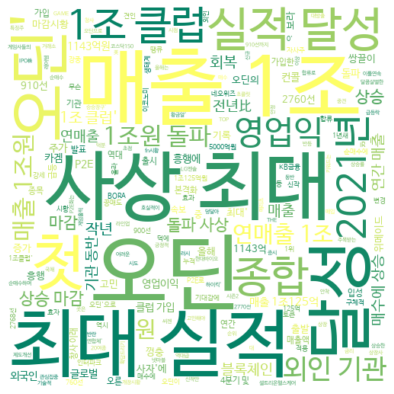

In [ ]:
# ㅇ월 ㅇ일 긍정 클라우드 [수작업 라벨링]

stopwords = ['카카오게임즈', '카카오', '게임', '우마', '무스', '메', '황', '非', '코스피', '코스닥', '지난해']
positive_words =' '.join([text for text in first['제목'][first['긍부정'] == 2]])
#im = Image.open('/content/blackwhite.PNG')
#mask_arr = np.array(im)
font = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

wordcloud = WordCloud(stopwords=stopwords, font_path= font, width=500, height=500, background_color='white', colormap='summer', random_state=21, max_font_size=110,).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("model_korean_webtoon_pos.png")

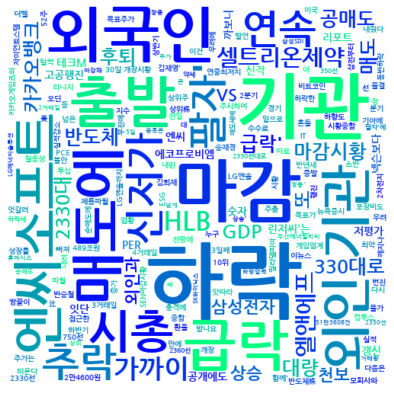

In [ ]:
# ㅇ월 ㅇ일 부정 클라우드 [핀버트 라벨링]

negative_words =' '.join([text for text in second['제목'][second['긍부정'] == 0] if len(text) >= 2])
#im = Image.open('/content/blackwhite.PNG')
#mask_arr = np.array(im)

wordcloud = WordCloud(stopwords=stopwords, font_path= path, width=500, height=500, background_color='white', colormap='winter', random_state=21, max_font_size=110,).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("model_korean_webtoon_pos.png")

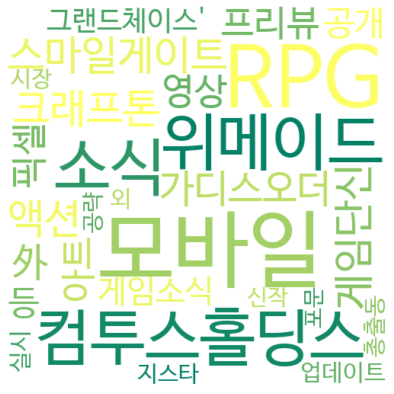

In [ ]:
# ㅇ월 ㅇ일 긍정 클라우드 [수작업 라벨링]

stopwords = ['카카오게임즈', '카카오', '게임', '우마', '무스', '메', '황', '非']
positive_words =' '.join([text for text in third['제목'][['긍부정'] == 2] if len(text) >= 2])
#im = Image.open('/content/blackwhite.PNG')
#mask_arr = np.array(im)
font = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

wordcloud = WordCloud(stopwords=stopwords, font_path= font, width=500, height=500, background_color='white', colormap='summer', random_state=21, max_font_size=110,).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("model_korean_webtoon_pos.png")

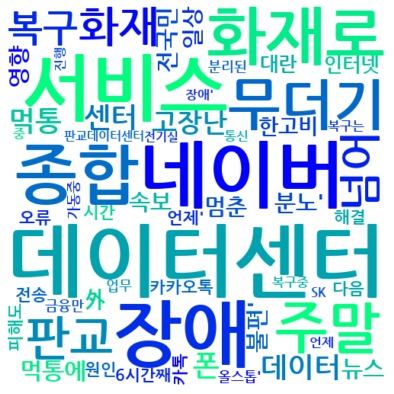

In [ ]:
# ㅇ월 ㅇ일 부정 클라우드 [핀버트 라벨링]

stopwords = ['카카오게임즈', '카카오', '게임', '우마', '무스', '메', '황', '非', '산', 'C', '종합2보', '아주경제', '줄', '오늘의', '종목현미경','넘겼는데']
negative_words =' '.join([text for text in third['제목'][third['긍부정'] == 0] if len(text) >= 2])
#im = Image.open('/content/blackwhite.PNG')
#mask_arr = np.array(im)

wordcloud = WordCloud(stopwords=stopwords, font_path= path, width=500, height=500, background_color='white', colormap='winter', random_state=21, max_font_size=110,).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("model_korean_webtoon_pos.png")

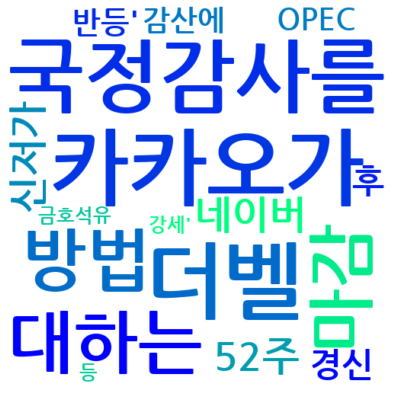

In [ ]:
# ㅇ월 ㅇ일 부정 클라우드 [핀버트 라벨링]

negative_words =' '.join([text for text in second['제목'][second['긍부정'] == 0] if len(text) >= 2])
#im = Image.open('/content/blackwhite.PNG')
#mask_arr = np.array(im)

wordcloud = WordCloud(stopwords=stopwords, font_path= path, width=500, height=500, background_color='white', colormap='winter', random_state=21, max_font_size=110,).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("model_korean_webtoon_pos.png")

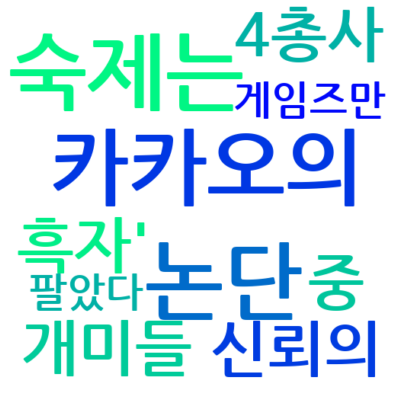

In [ ]:
# ㅇ월 ㅇ일 부정 클라우드 [핀버트 라벨링]

negative_words =' '.join([text for text in third['제목'][third['긍부정'] == 0] if len(text) >= 2])
#im = Image.open('/content/blackwhite.PNG')
#mask_arr = np.array(im)

wordcloud = WordCloud(stopwords=stopwords, font_path= path, width=500, height=500, background_color='white', colormap='winter', random_state=21, max_font_size=110,).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()
wordcloud.to_file("model_korean_webtoon_pos.png")

# 7. 연관 키워드 추출

In [ ]:
okt = Okt()

In [ ]:
nlp = [okt.nouns(i) for i in third['제목']]

In [ ]:
nlp

[['판교', '데이터', '센터', '화재', '카카오', '주말', '무더기', '먹통'],
 ['폰', '고장', '줄', '카카오', '먹통', '국민', '불편', '분노', '종합'],
 ['속보', '카카오', '서비스', '주말', '무더기', '장애', '판교', '데이터', '센터', '화재', '영향'],
 ['아주경제',
  '오늘',
  '뉴스',
  '종합',
  '데이터',
  '센터',
  '화재',
  '일상',
  '카카오',
  '네이버',
  '서비스',
  '장애'],
 ['종목', '현미경', '한고비', '카카오', '게임', '산', '산'],
 ['종합', '데이터', '센터', '화재', '카카오', '네이버', '서비스', '장애', '주말', '인터넷', '대란'],
 ['종합',
  '카카오',
  '톡',
  '카톡',
  '전송',
  '오류',
  '원인',
  '복구',
  '시간',
  '해결',
  '언제',
  '네이버',
  '다음',
  '피해'],
 ['스톱', '카카오', '데이터', '센터', '분리', '업무', '금융', '가동'],
 ['데이터', '센터', '화재', '카카오', '네이버', '서비스', '무더기', '장애', '복구', '종합', '보'],
 ['데이터', '센터', '화재', '카카오', '네이버', '서비스', '장애', '복구', '진행', '중'],
 ['웃음',
  '카카오',
  '게임',
  '카카오',
  '미투',
  '온',
  '삼성',
  '전자',
  '비',
  '덴트',
  '위메이드',
  '기술',
  '평가',
  '왜'],
 ['카카오', '통신', '장애', '복구', '언제', '판교', '데이터', '센터', '전기', '실']]

In [ ]:
model = Word2Vec(nlp, sg=1, window=3, min_count=1, workers=4, iter=1)
model.init_sims(replace=True)

In [ ]:
model_result1 = model.wv.most_similar('화재', topn=50)
print(model_result1)

[('장애', 0.2245773822069168), ('일상', 0.21919995546340942), ('줄', 0.17307573556900024), ('보', 0.1593053936958313), ('업무', 0.14145123958587646), ('고장', 0.13752152025699615), ('뉴스', 0.13526897132396698), ('평가', 0.1312069445848465), ('왜', 0.12524119019508362), ('삼성', 0.11015397310256958), ('위메이드', 0.1086372658610344), ('다음', 0.09917378425598145), ('진행', 0.0922076404094696), ('금융', 0.08620265871286392), ('폰', 0.08012831956148148), ('분리', 0.07482879608869553), ('분노', 0.07338637113571167), ('대란', 0.06895819306373596), ('미투', 0.054119959473609924), ('주말', 0.053744759410619736), ('오류', 0.05234573781490326), ('시간', 0.05141524598002434), ('오늘', 0.04465988278388977), ('카톡', 0.039857394993305206), ('영향', 0.03889308124780655), ('한고비', 0.03194693103432655), ('불편', 0.02948429435491562), ('종목', 0.02551165223121643), ('종합', 0.021198639646172523), ('국민', 0.018838685005903244), ('원인', -0.0032956674695014954), ('중', -0.0071578435599803925), ('카카오', -0.009174691513180733), ('데이터', -0.00956810638308525), ('먹통